# Import Libraries

In [3]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import *
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)


/kaggle/input/retail-store-inventory-forecasting-dataset/retail_store_inventory.csv


# Data Load

In [4]:
df = pd.read_csv("/kaggle/input/retail-store-inventory-forecasting-dataset/retail_store_inventory.csv")

In [5]:
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [6]:
df.shape

(73100, 15)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [8]:
df = df.rename(columns={'Inventory Level': 'Inventory', 
                        'Units Sold': 'Sales', 
                        'Units Ordered': 'Orders', 
                        'Demand Forecast': 'Demand', 
                        'Weather Condition': 'Weather', 
                        'Holiday/Promotion': 'Promotion', 
                        'Competitor Pricing': 'Competitor Price'})

# EDA & Visualization

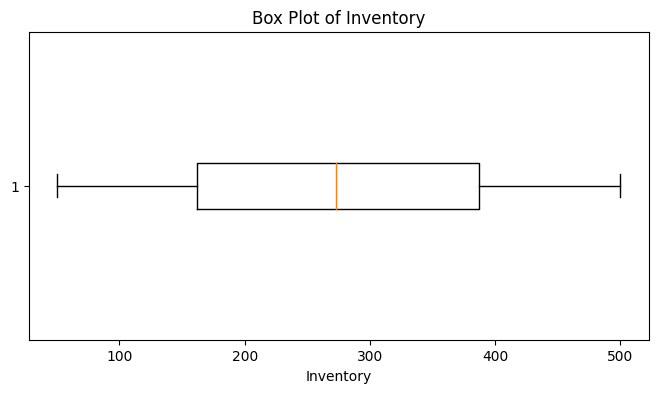

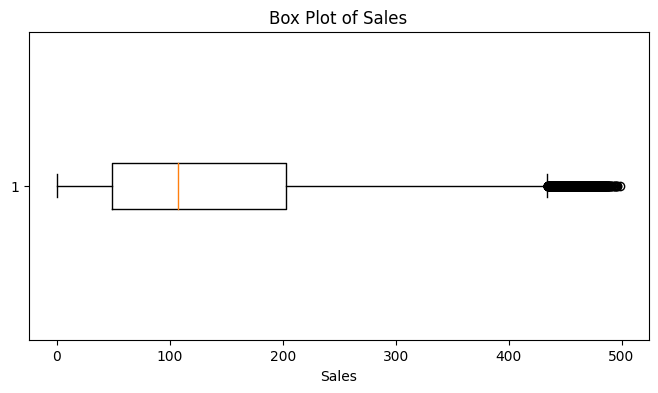

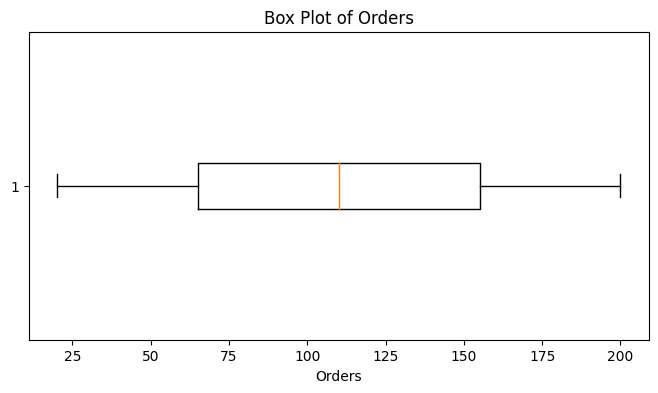

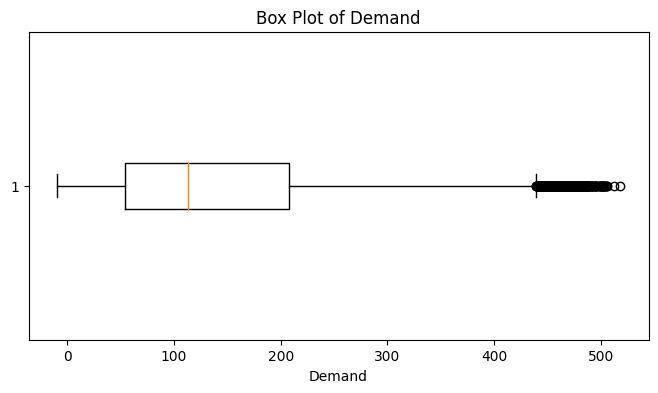

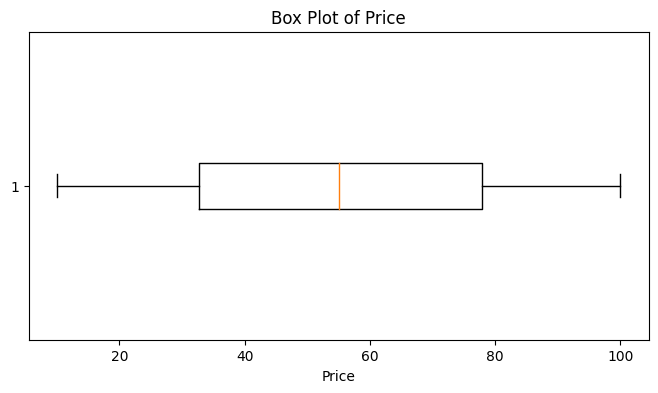

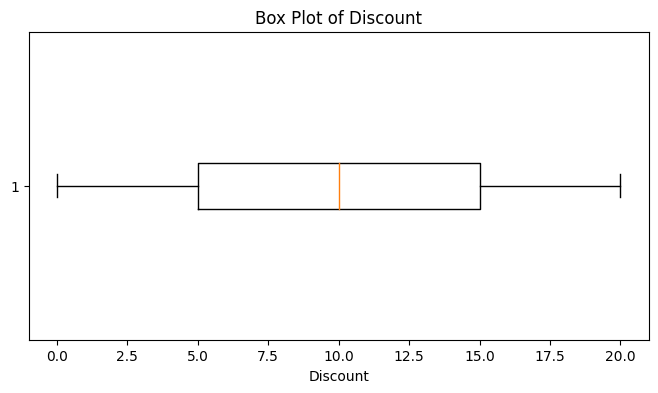

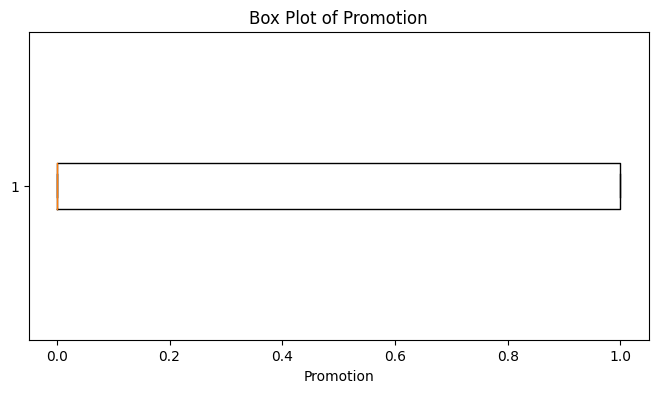

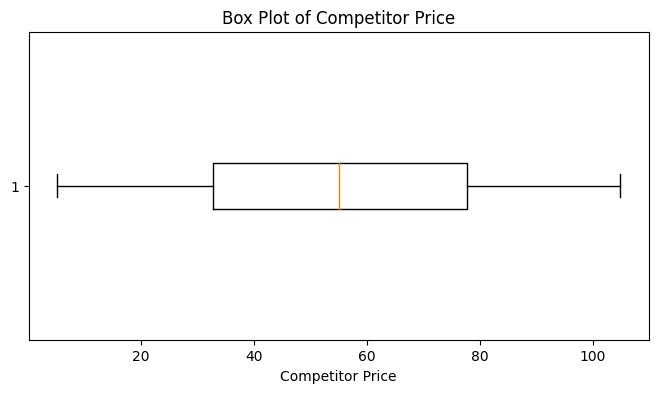

In [9]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))  
    plt.boxplot(df[col].dropna(), vert=False)  
    plt.title(f"Box Plot of {col}") 
    plt.xlabel(col) 
    plt.show() 

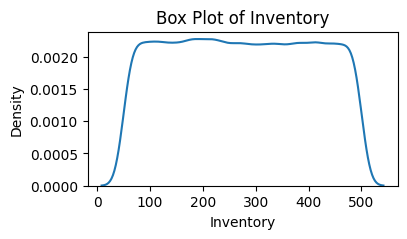

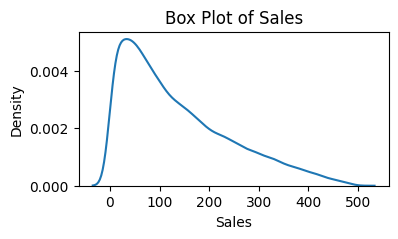

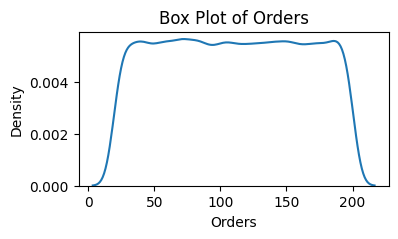

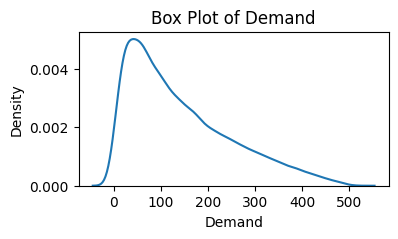

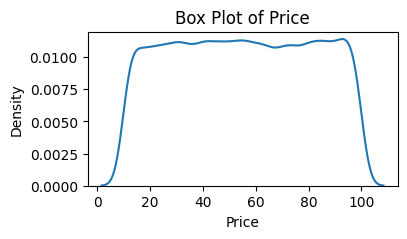

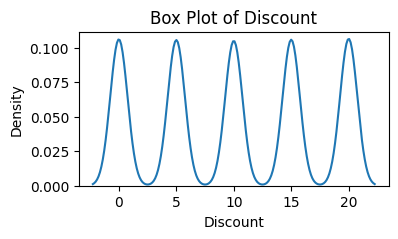

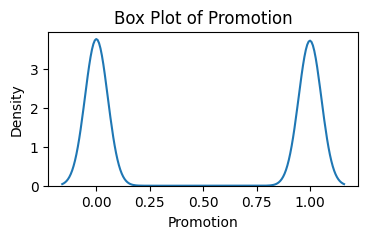

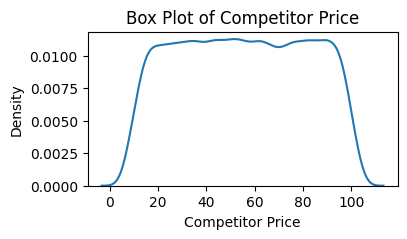

In [10]:
for col in numeric_cols:
    plt.figure(figsize=(4, 2))  
    sns.kdeplot(df[col].dropna())  
    plt.title(f"Box Plot of {col}") 
    plt.xlabel(col) 
    plt.show() 

The **Sales** Column is *left skewed* and we need to make that Normal as it has *Outliers*

In [11]:
from scipy.stats import zscore

z_scores = df[numeric_cols].apply(zscore)

df_cleaned = df[(z_scores <= 3).all(axis=1)]

for column in numeric_cols:
    z_scores = zscore(df_cleaned[column])
    outliers = df_cleaned[(z_scores > 3) | (z_scores < -3)]
    print(f"{column} outliers count: {outliers[column].count()}")


Inventory outliers count: 0
Sales outliers count: 52
Orders outliers count: 0
Demand outliers count: 44
Price outliers count: 0
Discount outliers count: 0
Promotion outliers count: 0
Competitor Price outliers count: 0


In [12]:
for column in numeric_cols:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

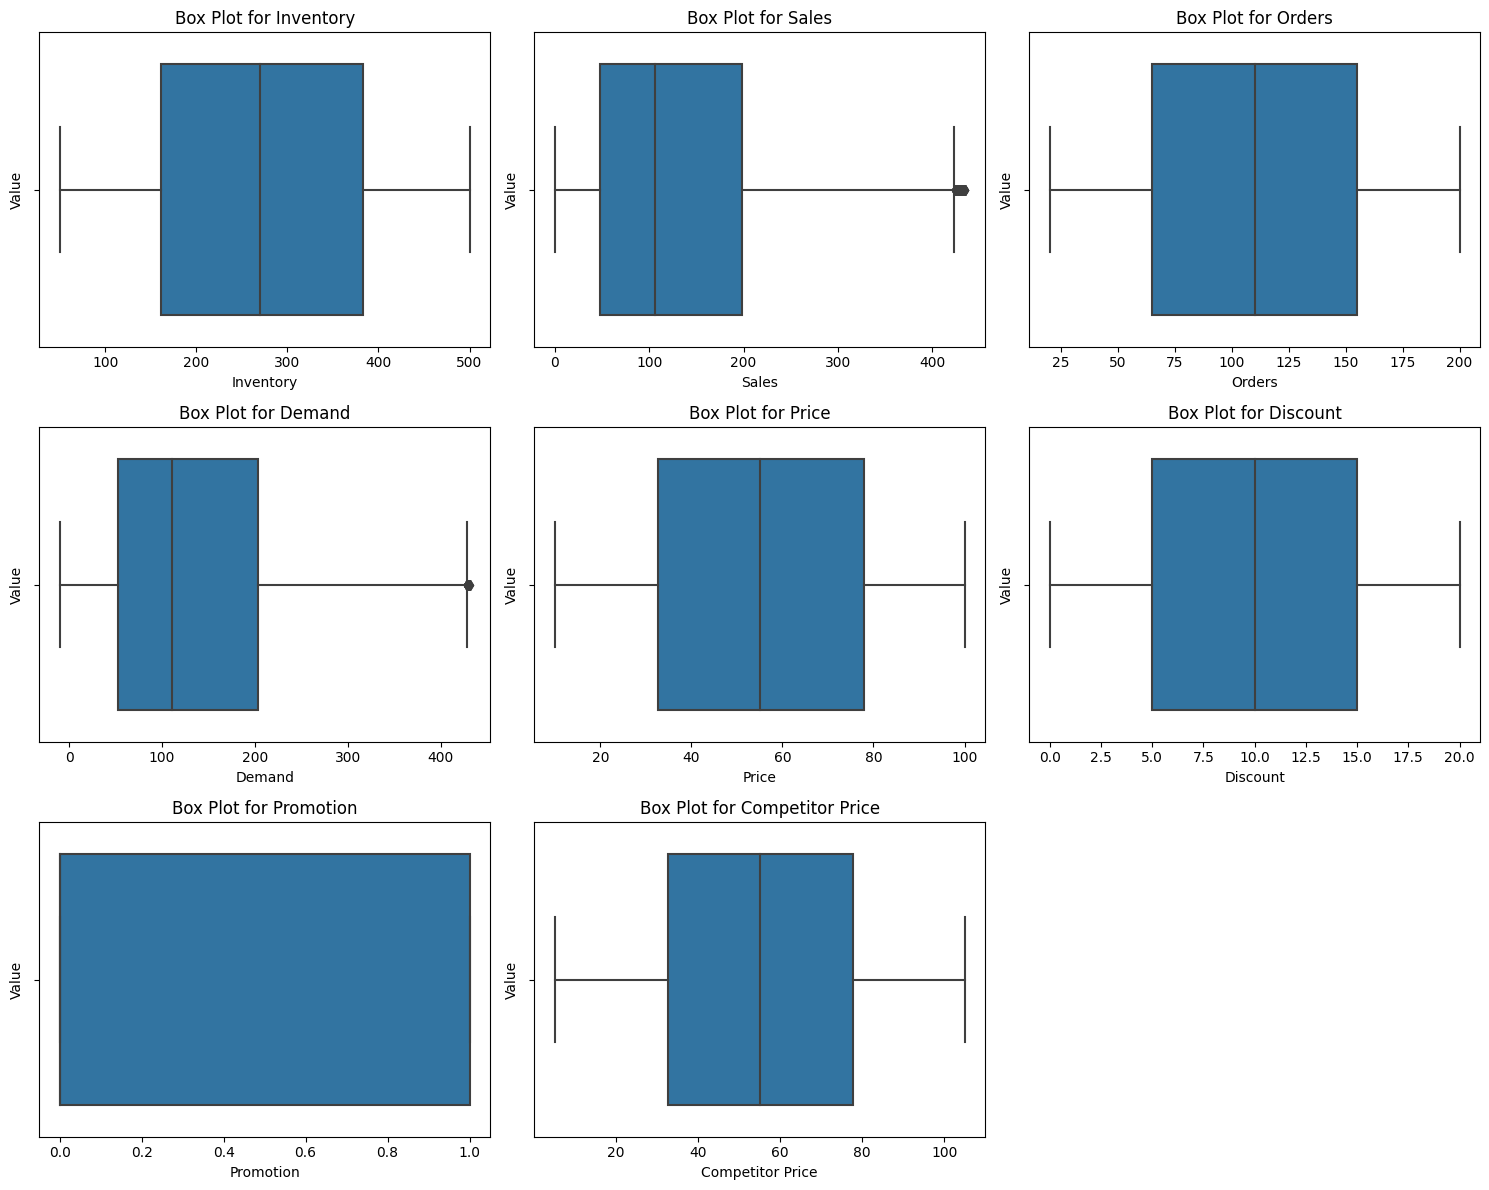

In [13]:
n_cols = 3  
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()
for i, column in enumerate(numeric_cols):
    sns.boxplot(data=df, x=column, ax=axes[i])
    axes[i].set_title(f'Box Plot for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Value')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<Axes: xlabel='Sales', ylabel='Count'>

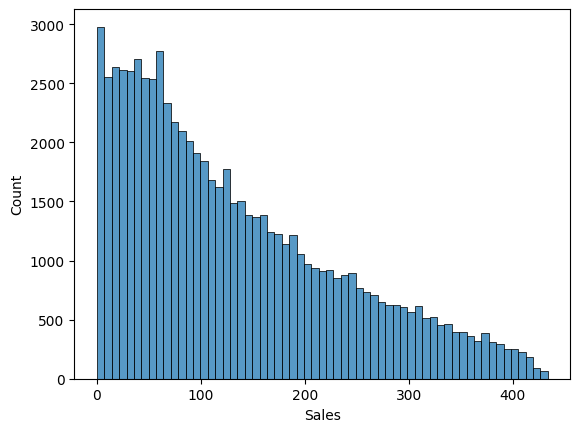

In [14]:
sns.histplot(df['Sales'])

<Axes: xlabel='Demand', ylabel='Count'>

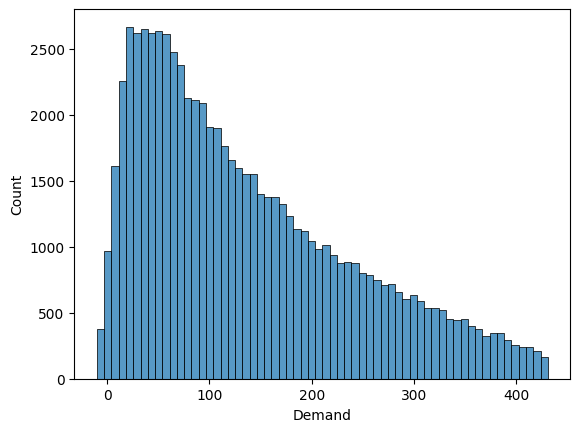

In [15]:
sns.histplot(df['Demand'])

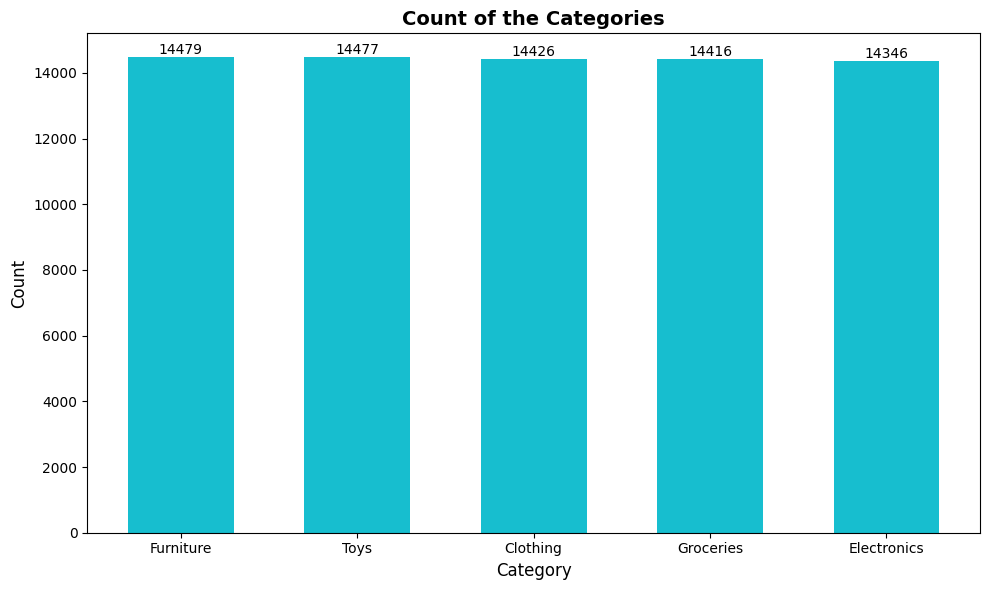

In [16]:

CategoryCounts = df['Category'].value_counts().reset_index()
CategoryCounts.columns = ['Category', 'count'] 
plt.figure(figsize=(10, 6))  
bars = plt.bar(CategoryCounts['Category'], CategoryCounts['count'], color='#17becf', width=0.6)

plt.title('Count of the Categories', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

plt.tight_layout() 
plt.show()

In [17]:
cat_df = df.select_dtypes(["object"])

In [18]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72144 entries, 0 to 73099
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         72144 non-null  object
 1   Store ID     72144 non-null  object
 2   Product ID   72144 non-null  object
 3   Category     72144 non-null  object
 4   Region       72144 non-null  object
 5   Weather      72144 non-null  object
 6   Seasonality  72144 non-null  object
dtypes: object(7)
memory usage: 4.4+ MB


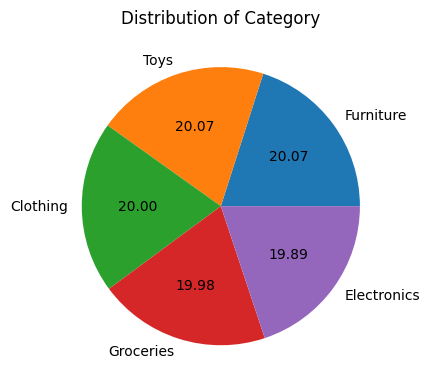

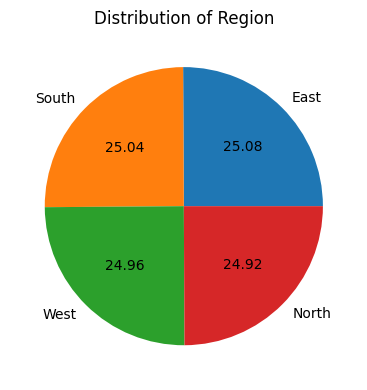

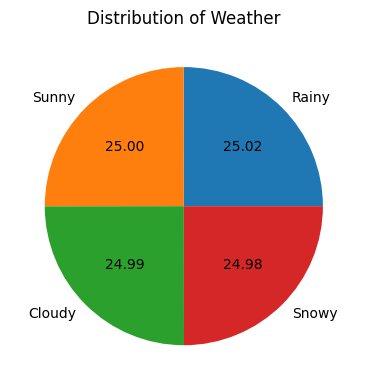

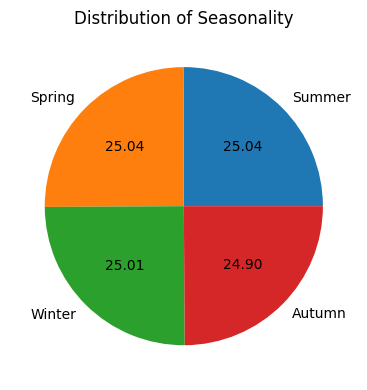

In [19]:
da = ['Category', 'Region', 'Weather', 'Seasonality']

for col in da:
    plt.figure(figsize=(5, 4))  
    df[col].value_counts().plot(kind="pie", autopct="%.2f", ylabel='')
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


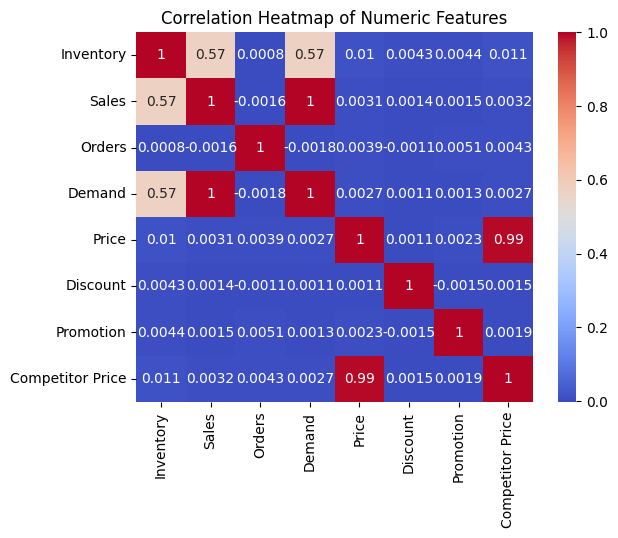

In [20]:
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [21]:
df["Promotion"].value_counts()

Promotion
0    36245
1    35899
Name: count, dtype: int64

<Axes: xlabel='Inventory', ylabel='Sales'>

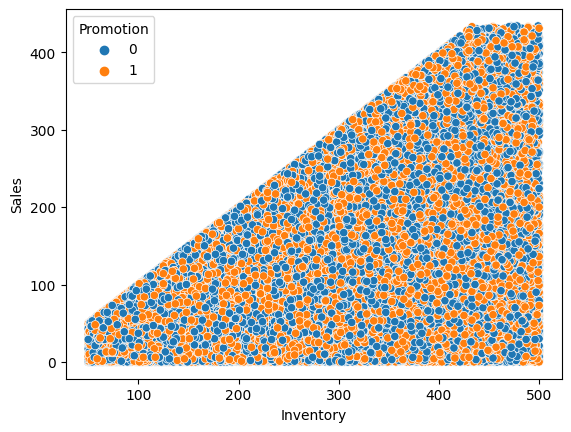

In [22]:
sns.scatterplot(data=df, x='Inventory', y='Sales',hue="Promotion")

<Axes: xlabel='Demand_Gap', ylabel='Count'>

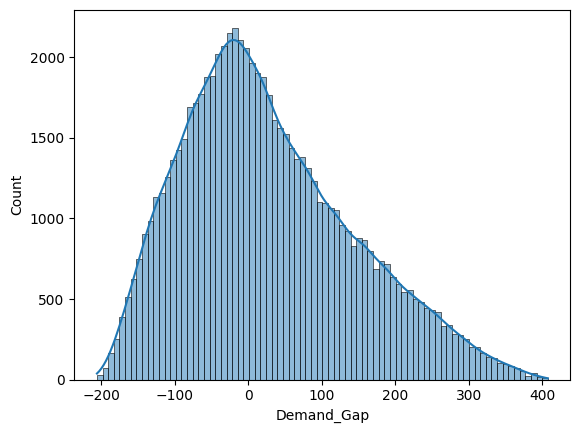

In [23]:
df['Demand_Gap'] = df['Demand'] - df['Orders']
sns.histplot(df['Demand_Gap'], kde=True)


<Axes: xlabel='Price', ylabel='Sales'>

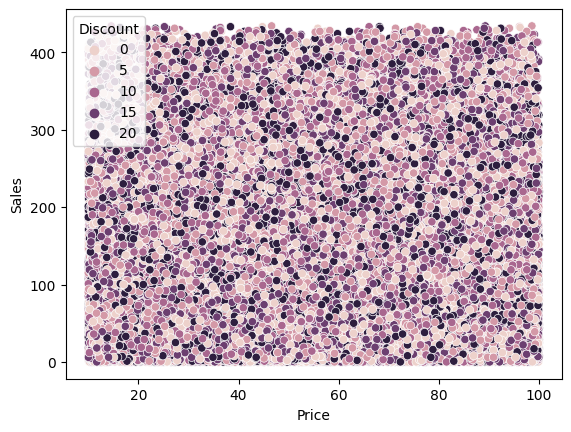

In [24]:
sns.scatterplot(data=df, x='Price', y='Sales', hue='Discount')


<Axes: xlabel='Promotion', ylabel='Sales'>

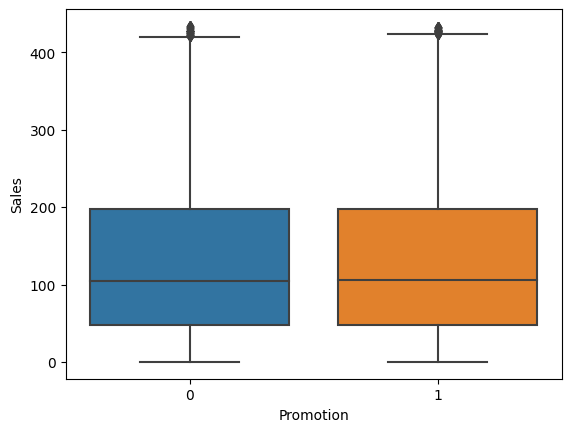

In [25]:
sns.boxplot(data=df, x='Promotion', y='Sales')


<Axes: xlabel='Price_Diff', ylabel='Count'>

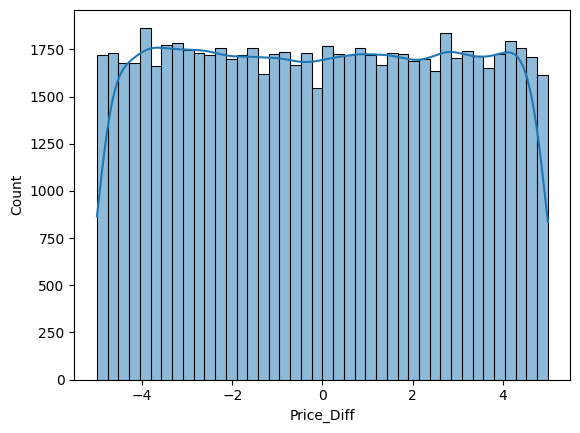

In [26]:
df['Price_Diff'] = df['Price'] - df['Competitor Price']
sns.histplot(df['Price_Diff'], kde=True)


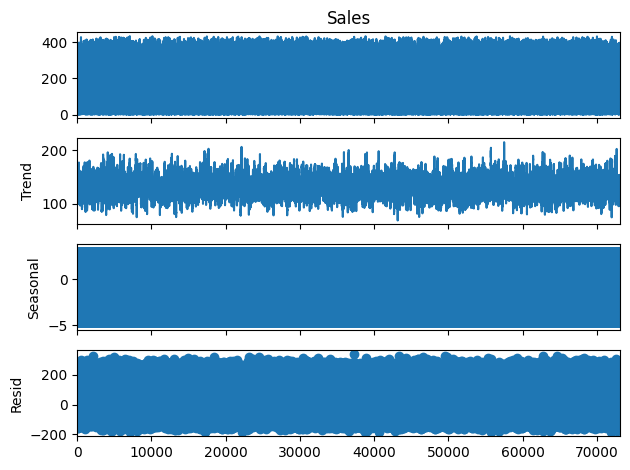

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df['Sales'], model='additive', period=30)
result.plot()
plt.tight_layout()
plt.show()


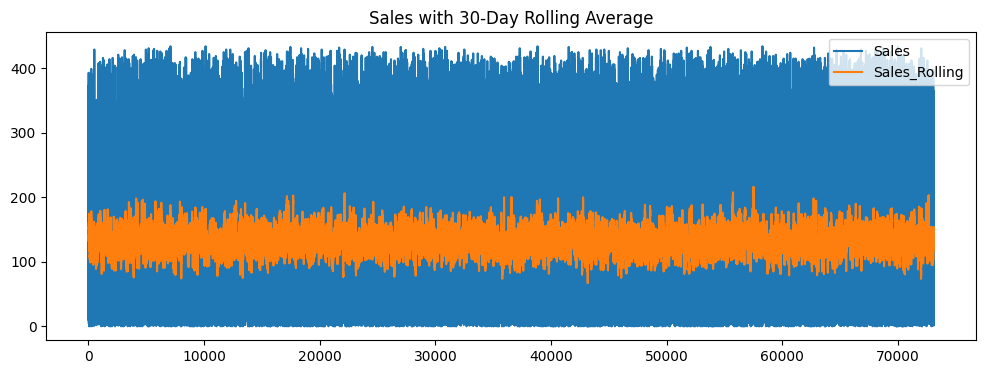

In [28]:
df['Sales_Rolling'] = df['Sales'].rolling(window=30).mean()
df['Demand_Rolling'] = df['Demand'].rolling(window=30).mean()

df[['Sales', 'Sales_Rolling']].plot(figsize=(12, 4))
plt.title("Sales with 30-Day Rolling Average")
plt.show()


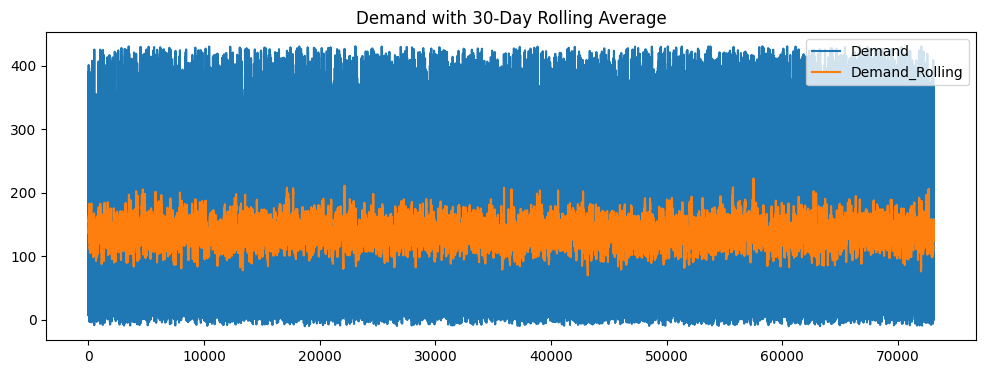

In [29]:
df[['Demand', 'Demand_Rolling']].plot(figsize=(12, 4))
plt.title("Demand with 30-Day Rolling Average")
plt.show()

In [30]:
shopsale = df.groupby("Store ID").agg(
    Order_Count=("Orders", "count"),
    Total_Orders=("Orders", "sum")  
).reset_index()


In [31]:
shopsale

,Store ID,Order_Count,Total_Orders
0,S001,14441,1593088
1,S002,14427,1583882
2,S003,14422,1583207
3,S004,14436,1587333
4,S005,14418,1587893


In [32]:
prodsale = df.groupby("Product ID").agg(
    Order_Count=("Orders", "count"),
    Total_Orders=("Orders", "sum")  
).reset_index()


In [33]:
prodsale

,Product ID,Order_Count,Total_Orders
0,P0001,3609,402849
1,P0002,3608,396664
2,P0003,3617,398599
3,P0004,3610,390417
4,P0005,3622,396919
5,P0006,3610,391259
6,P0007,3586,390127
7,P0008,3606,398089
8,P0009,3600,393091
9,P0010,3590,399675


In [34]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month  
df['Days'] = df['Date'].dt.day 

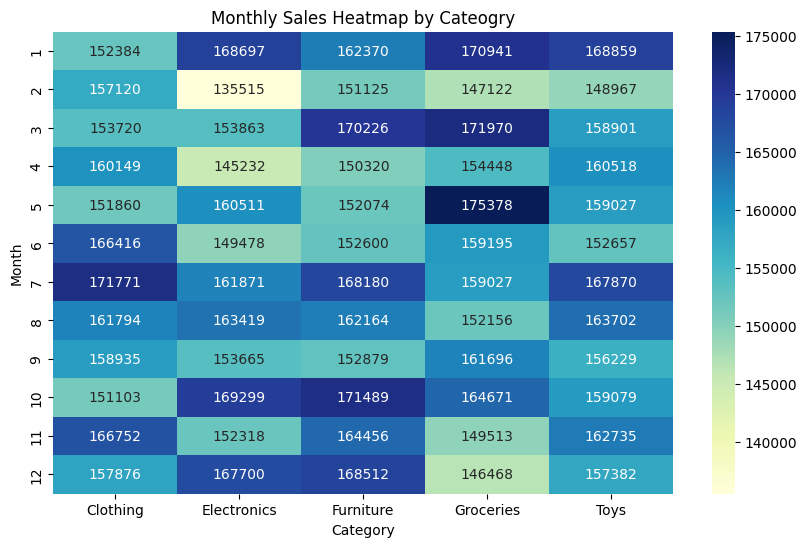

In [35]:

pivot = df.pivot_table(index='Month', columns='Category', values='Sales', aggfunc='sum')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Monthly Sales Heatmap by Cateogry")
plt.show()


In [36]:
df.drop(columns=["Date","Store ID","Product ID"],axis=1,inplace=True)

In [37]:
df.describe()

,Inventory,Sales,Orders,Demand,Price,Discount,Promotion,Competitor Price,Demand_Gap,Price_Diff,Sales_Rolling,Demand_Rolling,Month,Days
count,72144.000000,72144.000000,72144.000000,72144.000000,72144.000000,72144.000000,72144.000000,72144.000000,72144.000000,72144.000000,72115.000000,72115.000000,72144.000000,72144.000000
mean,271.818987,132.323603,109.993943,137.331017,55.150677,10.006653,0.497602,55.160783,27.337074,-0.010106,132.320953,137.329251,6.518907,15.699365
std,128.719206,103.462262,52.269996,103.752148,26.026312,7.084138,0.499998,26.195340,116.257698,2.889424,18.732457,18.811879,3.452338,8.809887
min,50.000000,0.000000,20.000000,-9.990000,10.000000,0.000000,0.000000,5.030000,-206.040000,-5.000000,66.933333,70.172667,1.000000,1.000000
25%,161.000000,48.000000,65.000000,53.067500,32.647500,5.000000,0.000000,32.680000,-58.770000,-2.530000,119.333333,124.252167,4.000000,8.000000
50%,270.000000,106.000000,110.000000,111.100000,55.070000,10.000000,0.000000,55.030000,9.175000,0.000000,131.800000,136.859667,7.000000,16.000000
75%,383.000000,198.000000,155.000000,202.932500,77.882500,15.000000,1.000000,77.850000,101.055000,2.510000,144.633333,149.756667,10.000000,23.000000
max,500.000000,434.000000,200.000000,430.970000,100.000000,20.000000,1.000000,104.940000,407.970000,5.000000,216.266667,222.894333,12.000000,31.000000


In [38]:
month_price_comp = df.groupby("Month").agg(
    Month_Price = ("Price", "sum"),
    Month_Comp_Price = ("Competitor Price", "sum")
)

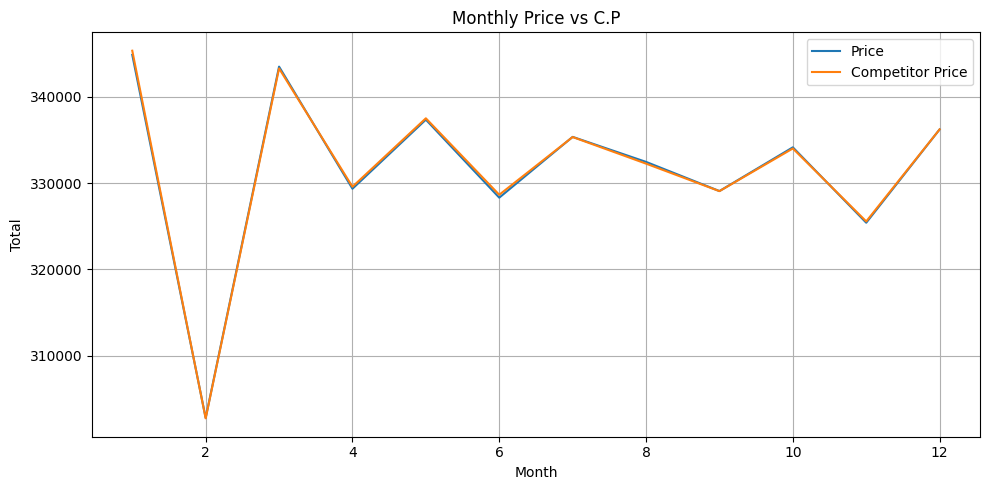

In [39]:
month_price_comp.sort_values("Month", inplace=True)

plt.figure(figsize=(10, 5))
sns.lineplot(data=month_price_comp, x="Month", y="Month_Price", label="Price")
sns.lineplot(data=month_price_comp, x="Month", y="Month_Comp_Price", label="Competitor Price")
plt.title("Monthly Price vs C.P")
plt.xlabel("Month")
plt.ylabel("Total")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
month_invent_sale = df.groupby("Month").agg(
    Month_Inventory = ("Inventory", "sum"),
    Month_Sales = ("Sales", "sum")
)

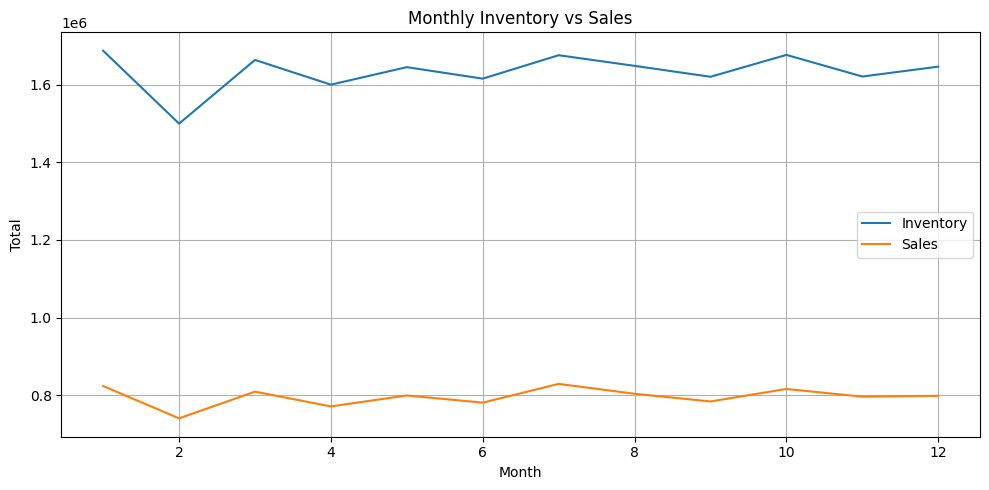

In [41]:
month_invent_sale.sort_values("Month", inplace=True)

plt.figure(figsize=(10, 5))
sns.lineplot(data=month_invent_sale, x="Month", y="Month_Inventory", label="Inventory")
sns.lineplot(data=month_invent_sale, x="Month", y="Month_Sales", label="Sales")
plt.title("Monthly Inventory vs Sales")
plt.xlabel("Month")
plt.ylabel("Total")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [42]:
df.sample()

,Category,Region,Inventory,Sales,Orders,Demand,Price,Discount,Weather,Promotion,Competitor Price,Seasonality,Demand_Gap,Price_Diff,Sales_Rolling,Demand_Rolling,Month,Days
35678,Clothing,South,62,51,53,43.05,55.34,5,Rainy,1,55.7,Winter,-9.95,-0.36,138.1,142.956333,12,23


In [43]:
cat = pd.get_dummies(df,columns=da,drop_first=True )

In [44]:
data = df[numeric_cols].merge(cat)

In [45]:
data.sample(6)

,Inventory,Sales,Orders,Demand,Price,Discount,Promotion,Competitor Price,Demand_Gap,Price_Diff,...,Category_Toys,Region_North,Region_South,Region_West,Weather_Rainy,Weather_Snowy,Weather_Sunny,Seasonality_Spring,Seasonality_Summer,Seasonality_Winter
16390,142,137,166,151.37,30.91,15,1,30.32,-14.63,0.59,...,False,False,True,False,False,True,False,False,False,True
1305,269,48,154,55.33,31.62,10,1,33.67,-98.67,-2.05,...,False,False,False,True,False,False,False,False,False,False
58759,318,52,56,62.09,80.15,10,1,76.98,6.09,3.17,...,True,False,True,False,False,True,False,False,False,True
21168,493,330,90,344.53,70.77,0,1,69.40,254.53,1.37,...,False,False,False,True,True,False,False,True,False,False
53250,52,28,29,37.80,93.53,20,1,97.13,8.80,-3.60,...,False,True,False,False,True,False,False,False,True,False
11158,364,5,189,10.29,33.03,10,1,30.50,-178.71,2.53,...,False,False,False,True,True,False,False,False,True,False


In [46]:
most_demand = df[df["Demand"] >= 200].sort_values("Orders",ascending=False)

In [47]:
most_demand.max()

Category                  Toys
Region                    West
Inventory                  500
Sales                      434
Orders                     200
Demand                  430.97
Price                    99.99
Discount                    20
Weather                  Sunny
Promotion                    1
Competitor Price        104.58
Seasonality             Winter
Demand_Gap              407.97
Price_Diff                 5.0
Sales_Rolling       216.266667
Demand_Rolling      222.894333
Month                       12
Days                        31
dtype: object

In [48]:
data.drop(["Price_Diff","Demand_Gap","Sales_Rolling","Demand_Rolling"],axis=1,inplace=True)

In [49]:
df.dropna()

,Category,Region,Inventory,Sales,Orders,Demand,Price,Discount,Weather,Promotion,Competitor Price,Seasonality,Demand_Gap,Price_Diff,Sales_Rolling,Demand_Rolling,Month,Days
29,Electronics,North,157,126,181,132.75,60.84,0,Snowy,1,65.22,Winter,-48.25,-4.38,140.500000,143.044333,1,1
30,Groceries,West,67,13,33,7.44,34.62,0,Snowy,1,33.98,Autumn,-25.56,0.64,136.700000,138.776667,1,1
31,Groceries,East,281,25,136,37.27,19.56,5,Rainy,1,19.01,Winter,-98.73,0.55,132.533333,135.217667,1,1
32,Clothing,East,389,283,177,299.70,57.78,20,Cloudy,0,58.50,Spring,122.70,-0.72,139.800000,142.740333,1,1
33,Electronics,East,465,359,77,370.36,91.28,20,Cloudy,0,90.85,Summer,293.36,0.43,149.733333,153.013000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73095,Furniture,East,96,8,127,18.46,73.73,20,Snowy,0,72.45,Winter,-108.54,1.28,140.566667,145.007667,1,1
73096,Toys,North,313,51,101,48.43,82.57,10,Cloudy,0,83.78,Autumn,-52.57,-1.21,138.366667,142.753333,1,1
73097,Clothing,West,278,36,151,39.65,11.11,10,Rainy,0,10.91,Winter,-111.35,0.20,127.400000,131.778000,1,1
73098,Toys,East,374,264,21,270.52,53.14,20,Rainy,0,55.80,Spring,249.52,-2.66,134.633333,138.564000,1,1


In [50]:
y = data['Demand']
X = data.drop("Demand",axis=1)

# Spliting & Scaling

In [51]:
X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [52]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

          
print(X_train.shape)           
print(X_train_scaled.shape) 

(57715, 22)
(57715, 22)


In [53]:
print("NaNs in X_train:\n", X_train.isnull().sum())


NaNs in X_train:
 Inventory               0
Sales                   0
Orders                  0
Price                   0
Discount                0
Promotion               0
Competitor Price        0
Month                   0
Days                    0
Category_Electronics    0
Category_Furniture      0
Category_Groceries      0
Category_Toys           0
Region_North            0
Region_South            0
Region_West             0
Weather_Rainy           0
Weather_Snowy           0
Weather_Sunny           0
Seasonality_Spring      0
Seasonality_Summer      0
Seasonality_Winter      0
dtype: int64


# Model training & Evaluation

In [54]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'SGD': SGDRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'RANSAC': RANSACRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    
}


results = []

for name, model in models.items():
    print(f"\n🔧 Training {name}...")

    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"📐 MSE: {mse:.4f}")
        print(f"📐 MAE: {mae:.4f}")
        print(f"📈 R² Score: {r2:.4f}")

        results.append((name, r2)) 

    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"📐 MSE: {mse:.4f}")
        print(f"📐 MAE: {mae:.4f}")
        print(f"📈 R² Score: {r2:.4f}")

        results.append((name, r2))  
best_model = max(results, key=lambda x: x[1])
print(f"\n🏆 Best Model: {best_model[0]} with Score: {best_model[1]:.4f}")



🔧 Training Linear Regression...
📐 MSE: 75.1492
📐 MAE: 7.4963
📈 R² Score: 0.9931

🔧 Training Ridge...
📐 MSE: 75.1492
📐 MAE: 7.4963
📈 R² Score: 0.9931

🔧 Training Lasso...
📐 MSE: 75.1071
📐 MAE: 7.4954
📈 R² Score: 0.9931

🔧 Training ElasticNet...
📐 MSE: 75.1039
📐 MAE: 7.4952
📈 R² Score: 0.9931

🔧 Training SGD...
📐 MSE: 116378909495370614235463680.0000
📐 MAE: 10126708140015.1445
📈 R² Score: -10667535585513343811584.0000

🔧 Training Bayesian Ridge...
📐 MSE: 75.1423
📐 MAE: 7.4962
📈 R² Score: 0.9931

🔧 Training RANSAC...
📐 MSE: 75.1592
📐 MAE: 7.4966
📈 R² Score: 0.9931

🔧 Training Decision Tree...
📐 MSE: 154.4925
📐 MAE: 10.1477
📈 R² Score: 0.9858

🔧 Training Random Forest...
📐 MSE: 79.3924
📐 MAE: 7.6248
📈 R² Score: 0.9927

🔧 Training Gradient Boosting...
📐 MSE: 75.8456
📐 MAE: 7.5122
📈 R² Score: 0.9930

🏆 Best Model: ElasticNet with Score: 0.9931


**Our Best Model is *ElasticNet with Score: 0.9931***

In [55]:
model = ElasticNet()

In [56]:
model.fit(X_train_scaled, y_train)

ElasticNet()

# Pickle the Model

In [58]:
import pickle

# Save model
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
